# **AM 207**: Homework 2

Verena Kaynig-Fittkau and Pavlos Protopapas  <br>
**Due: 11.59 P.M. Thursday March 3rd, 2015**

### Instructions:

+ Upload your answers in an ipython notebook to Canvas.

+ We will provide you imports for your ipython notebook. Please do not import additional libraries.

+ Your individual submissions should use the following filenames: AM207_YOURNAME_HW2.ipynb

+ Your code should be in code cells as part of your ipython notebook. Do not use a different language (or format). 

+ **Do not just send your code. The homework solutions should be in a report style. Be sure to add comments to your code as well as markdown cells where you describe your approach and discuss your results. **

+ Please submit your notebook in an executed status, so that we can see all the results you computed. However, we will still run your code and all cells should reproduce the output when executed. 

+ If you have multiple files (e.g. you've added code files or images) create a tarball for all files in a single file and name it: AM207_YOURNAME_HW2.tar.gz or AM207_YOURNAME_HW2.zip


### Have Fun!
_ _ _ _ _

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style("white")

import time
import timeit

import scipy.stats 
import pandas as pd
import pymc as pm

import re
import numpy as np

/Users/charlesliu/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


# Problem 1: Geweke Convergence Test

In the lecture we have seen the Geweke test as one option to test for convergence of our metropolis hastings chain. Describe in your own words how the Geweke test works and its limitations. 

We provide you with the following code for the Geweke test. Write comments for the marked lines and any lines you think would be good to explain in addition. 

Write a short explanation of what the `rhot` function does and why it is necessary. 

In [2]:
"""
The goal of an MCMC chain is to simulate a target posterior distribution.
However, early in the chain the target distribution has not been converged yet.
The idea behind the Geweke test is to compare the distributions from the early
part of a chain to the later part of the chain - if they are "similar" then at
some point in the early part of the chain there was convergence to the distribution.

The rhot portion of the code is related to finding the variance of the subchains.
There is cross-correlation between the two chains we're comparing that is related
to the time lag between them. To calculate an adjusted estimate of the variance,
we have to calculate this summation of correlations within the subchains that gets
multiplied to our naive variance.
"""
# calculates the correlation between the first len(x)-t elements and the last len(x)-t elements
def rhot(x, t):
    n = len(x)
    return np.corrcoef(x[0:(n-t)], x[t:n])[0,1]

# Function definition of Geweke convergence test
def Geweke(trace, intervals, length):
    nsl=length
    # how many elements to increment after every interval
    jump = int(0.9*len(trace)/(2*intervals))
    # how many elements to ignore from the beginning of the chain
    first = 0.1*len(trace)
    
    z =np.empty(intervals)
    # loop through to calculate geweke values intervals number of times
    for k in np.arange(0, intervals):
        # index for start of early chain
        baga = np.int(first+k*jump)
        # index for start of later chain
        bagb = len(trace)/2 + k*jump
        
        # getting the subchains to compare
        sub_trace_a = trace[baga:baga+nsl]
        sub_trace_b = trace[bagb:bagb+nsl]
        
        # getting the means of the subchains
        theta_a = np.mean(sub_trace_a)
        theta_b = np.mean(sub_trace_b)
        rho_a, rho_b = 1.0, 1.0
        # loop for adding correlations to adjust for autocorrelation
        for i in xrange(int(0.1*nsl)):
            # calculate correlations of front (i+1)/back (i+1) of subchains
            rho_a += 2*rhot(sub_trace_a, i+1)
            rho_b += 2*rhot(sub_trace_b, i+1)
            
        # autocorrelation adjusted estimates of variance of two subchains
        var_a  = np.var(sub_trace_a)*rho_a/length
        var_b  = np.var(sub_trace_b)*rho_b/length
        
        # z-score for the geweke test
        z[k] = (theta_a-theta_b)/np.sqrt( var_a + var_b)
    
    return z


# Problem 2: Message Response Times

The file `hangout_chat_data.csv` contains the response times of your friend Mark to google hangout chat messages in seconds. Use a method of your choice to read the file into a data frame or a numpy array. Your goal for this problem is to model Mark's chat response time distribution in a Bayesian framework. 

The description of the data sounds like a Poisson distribution is a good choice for our likelihood. We have messages arriving independently of each other, and instead of the arrival time we consider the time it took Mark to respond to the messages. 

* Load and describe the data by plotting a histogram of the response times. 
* Derive and compute the maximum likelihood solution for a Poisson distribution.
* Compare this to the Bayesian solution with a prior of your choice and using your own implementation of Metropolis Hastings to sample from the posterior. Make sure to describe why you chose this prior, as well as the specifics of your Metropolis Hastings implementation. 

* Analyze your sampling using traceplots and convergence tests. You can use the Geweke implementation given above. 
* Compare your solution to a solution using the MCMC class in pymc and write a brief discussion. Which parameters does your implementation need that the pymc implementation can do without? How do the traceplots compare? 

* Check your ML solution and the Bayesian solution against the data. If you know how you can use the posterior predictive for the Bayesian solution, otherwise you can use the MAP estimate or the expectation value of the posterior and compare that distribution to the data histogram. 

* Was our model a good choice for this problem? If yes great, if not, come up with a different Bayesian model that is better capable of capturing the data and show that it works better. 


(array([ 41.,  70.,  44.,  33.,  27.,  23.,   9.,   5.,   8.,   6.]),
 array([  0. ,   5.9,  11.8,  17.7,  23.6,  29.5,  35.4,  41.3,  47.2,
         53.1,  59. ]),
 <a list of 10 Patch objects>)

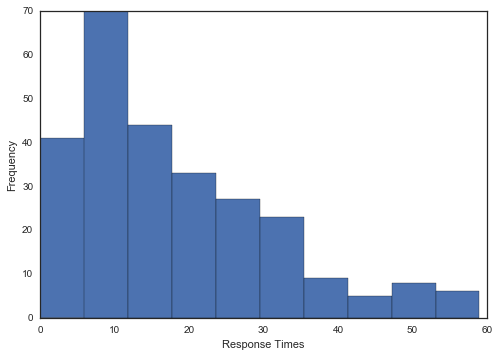

In [3]:
respTimes = np.loadtxt("hangout_chat_data.csv")
plt.xlabel("Response Times")
plt.ylabel("Frequency")
plt.hist(respTimes)

The distribution is centered around 10-20 seconds with some tail distribution on the longer response time up to 60 seconds

Each response follows a Poisson distribution where for $s$ seconds, $P(s) = \frac{e^{-\lambda}\lambda^s}{s!}$.
Likelihood of our data of $N$ i.i.d Poisson variables $s_1, s_2, ..., s_n$ is then:

$L(data|\lambda) = \frac{e^{-\lambda}\lambda^{s_1}}{s_1!}*\frac{e^{-\lambda}\lambda^{s_2}}{s_2!}*...*\frac{e^{-\lambda}\lambda^{s_n}}{s_n!}$

$logL(data|\lambda) = -N\lambda + (\sum_i s_i)log\lambda - \sum_i log(s_i!)$              (Eq 1)

Taking the derivative w.r.t. $\lambda$ we get:

$0 = -N + \frac{\sum_is_i}{\lambda} => \lambda = \frac{\sum_i s_i}{N}$

The second derivative results in $-\lambda^{-2}\sum_i s_i$, which since data points are always positive is a global optimum

In [4]:
#MLE of lambda is just the average of our data points
MLE = np.mean(respTimes)
MLE

18.041353383458645

We use Jeffrey's prior for the Poisson because of its invariant properties, which is $\lambda^{-0.5}$. The log of the posterior distribution is then $-.5log(\lambda) - N\lambda + (\sum_i s_i)log\lambda - \sum_i log(s_i!)$ (from Eq 1)

In [5]:
"""
Log posterior function
"""
#constant for the sum of response times
respSum = np.sum(respTimes)
#constant for sum of response time factorials
factSum = np.sum(map(lambda x: np.sum(map(lambda y: np.log(y), np.arange(1, x+1))), respTimes))
def posterior(l):
    return -.5*np.log(l)-len(respTimes)*l + respSum*np.log(l) - factSum

In [6]:
"""
Now we write our metropolis code using a normal dist with std dev 1 as proposal
"""
def metropolis(iterations):
    #chain of values
    trace = np.empty(iterations+1)
    #initialize lambda to be 1
    trace[0] = 1
    #current probability of lambda
    curr_prob = posterior(trace[0])
    for i in range(iterations):
        #proposed new value
        theta = np.random.normal(trace[i], 1)
        #new probability
        prob = posterior(theta)
        #acceptance probability
        accept_prob = prob - curr_prob
        if np.log(np.random.rand()) < accept_prob:
            trace[i+1] = theta
            curr_prob = prob
        else:
            trace[i+1] = trace[i]
    return trace

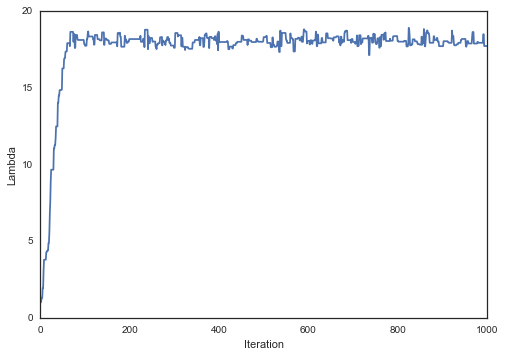

In [7]:
plt.xlabel("Iteration")
plt.ylabel("Lambda")
trace = metropolis(1000)
plt.plot(range(1001), trace)

We see lambda move towards the MLE that we obtained analytically in under 100 iterations and remain around there

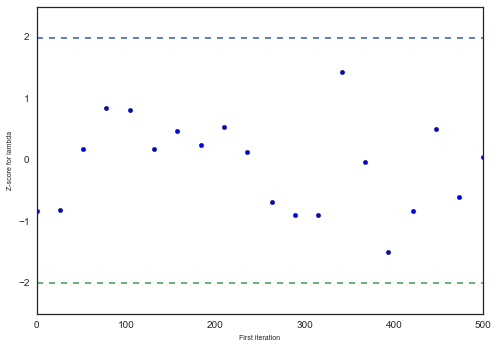

In [8]:
"""
Look at geweke score plot
"""
geweke_scores = pm.geweke(trace[:], first =0.1, last=0.5, intervals=20)
pm.Matplot.geweke_plot(geweke_scores, "lambda")

Our Geweke plot doesn't seem to look like it's converging, let's try a larger number of iterations

Estimated lambda: 18.0168504945
Estimated std dev: 0.656081072861


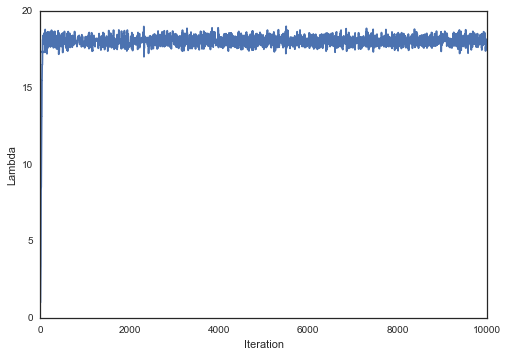

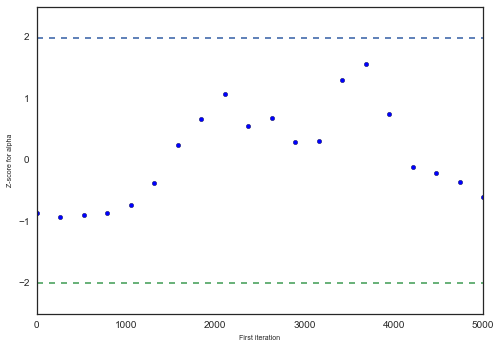

In [10]:
plt.xlabel("Iteration")
plt.ylabel("Lambda")
trace = metropolis(10000)
print "Estimated lambda:", np.mean(trace)
print "Estimated std dev:", np.std(trace)
plt.plot(range(10001), trace)
geweke_scores = pm.geweke(trace[:], first =0.1, last=0.5, intervals=20)
pm.Matplot.geweke_plot(geweke_scores, "alpha")

Our estimate is fairly close to the analytical solution, and all data points are within 2 std deviations. However, the z-scores are fairly spread out. Let's compare this to using pymc

In [11]:
wait_mean = pm.Exponential('wait_mean', beta=1.)
response_times = pm.Poisson('response_times', mu=wait_mean, value=respTimes, observed=True)
resp_model = pm.Model([wait_mean, response_times])
mcmc = pm.MCMC(resp_model)
mcmc.sample(iter=10000, burn=0)

 [-----------------100%-----------------] 10000 of 10000 complete in 0.7 sec

Estimated lambda: 17.4077533257
Estimated std dev: 2.58680659571


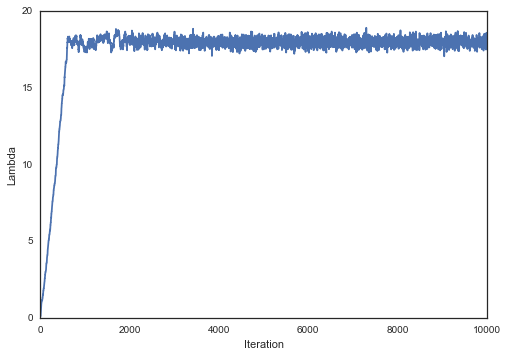

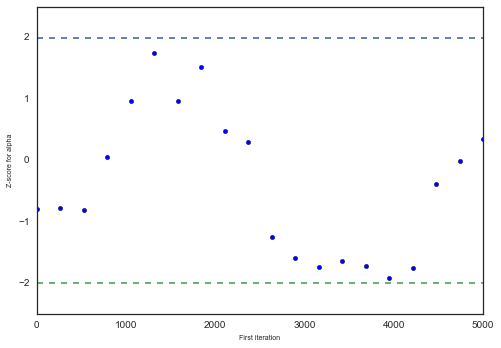

In [12]:
plt.xlabel("Iteration")
plt.ylabel("Lambda")
trace = wait_mean.trace()
print "Estimated lambda:", np.mean(trace)
print "Estimated std dev:", np.std(trace)
plt.plot(range(10000), trace)
geweke_scores = pm.geweke(trace[:], first =0.1, last=0.5, intervals=20)
pm.Matplot.geweke_plot(geweke_scores, "alpha")

The results from pymc were very similar to using Jeffrey's prior. With Jeffrey's prior there isn't any extra parameters that we have to deal with like if we were to use a gamma prior. Using an exponential in the pymc is essentially using a gamma distribution without an alpha, but we still have a hyperparameter of beta that could be tuned. Both results had geweke scores within 2 std deviations, however there was some variation within the 2 standard deviations - they aren't extremely tight bounds.

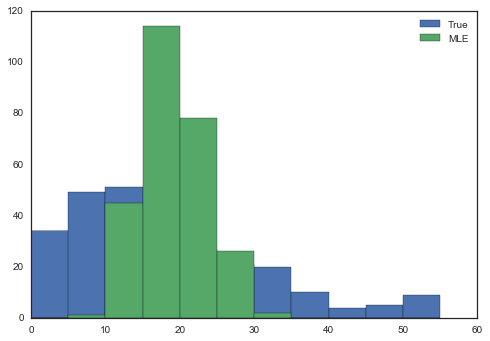

In [13]:
"""
Sample from the Poisson distribution with lambda = MLE and compare to the true distribution
"""
plt.hist(respTimes, bins=np.arange(0, 60, 5), label="True")
plt.hist(np.random.poisson(MLE, len(respTimes)), bins=np.arange(0, 60, 5), label="MLE")
plt.legend()

You can clearly see the issue with using strictly MLE - there is a large tail distribution for the true sample data which creates a slightly higher mean for the MLE. We then have a high concentration around that mean in the poisson distribution with not enough of a standard deviation.

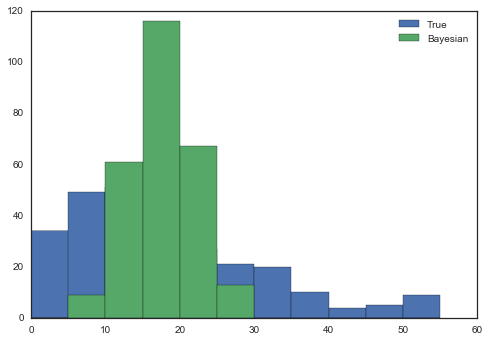

In [14]:
"""
Sample from the Poisson distribution with lambda = E[posterior] and compare to the true distribution
"""
plt.hist(respTimes, bins=np.arange(0, 60, 5), label="True")
plt.hist(np.random.poisson(np.mean(trace), len(respTimes)), bins=np.arange(0, 60, 5), label="Bayesian")
plt.legend()

It would seem the Poisson distribution doesn't have fat enough tails for what our data presents. Many exponential distributions may overall represent the data better, but the distribution must have a non-zero probability of returning 0 which is an issue for a lot of them. Couldn't find any distributions that fit that constraint.

# Problem 3: Markov Chains

* Given the following transition matrix, examine if the corresponding Markov Chain is irreducible and aperiodic. Note: No formal proof necessary, but you should give a solid argumentation.

$$ P = \left( 
\begin{array}{ccccc}
0.0 & 0.4 & 0.6 & 0.0 & 0.0 \\
0.65 & 0.0 & 0.35 & 0.0 & 0.0 \\
0.32 & 0.68 & 0.0 & 0.0 & 0.0 \\
0.0 & 0.0 & 0.0 & 0.12 & 0.88 \\
0.0 & 0.0 & 0.0 & 0.56 & 0.44 
\end{array}
\right ) $$



P is not irreducible - states 1,2,3 only have non-zero transition probabilities between them and likewise with states 4 and 5. 

In [15]:
P = np.matrix([[0.0, 0.4, 0.6, 0.0, 0.0],
               [0.65, 0.0, 0.35, 0.0, 0.0], 
               [0.32, 0.68, 0.0, 0.0, 0.0],
               [0.0, 0.0, 0.0, 0.12, 0.88],
               [0.0, 0.0, 0.0, 0.56, 0.44]])
P**2

matrix([[ 0.452 ,  0.408 ,  0.14  ,  0.    ,  0.    ],
        [ 0.112 ,  0.498 ,  0.39  ,  0.    ,  0.    ],
        [ 0.442 ,  0.128 ,  0.43  ,  0.    ,  0.    ],
        [ 0.    ,  0.    ,  0.    ,  0.5072,  0.4928],
        [ 0.    ,  0.    ,  0.    ,  0.3136,  0.6864]])

In [16]:
P**10000

matrix([[ 0.32987013,  0.34978355,  0.32034632,  0.        ,  0.        ],
        [ 0.32987013,  0.34978355,  0.32034632,  0.        ,  0.        ],
        [ 0.32987013,  0.34978355,  0.32034632,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        ,  0.38888889,  0.61111111],
        [ 0.        ,  0.        ,  0.        ,  0.38888889,  0.61111111]])

For n>1, $P(X_n = i | X_0 = i) > 0$ and eventually we can see an equilibrium transition matrix, which makes the markov chain aperiodic

# Problem 4: The Evidence 

In lectures we mostly concentrate on the likelihood and the prior and regard the evidence as a mere normalization factor. However, the evidence can be quite useful. In this problem you will compare different models by computing the evidence for each model, aka the probability that randomly selected parameters from a given model class would generate the data $X$.

As our models we compare polynomials of degree 0 to 4. For example for degree 2 we have $y = a_0 + a_1 \cdot x + a_2 \cdot x^2 + \epsilon$ where $\epsilon \sim N(0, \sigma) $ and $\theta = [a_0, a_1, a_2, \sigma]$. Assume that for all polynomials $a_i \sim \text{Expo}(1)$ and $\sigma \sim \text{Inverse Gamma}(1,1)$.


Bayes' theorem states that:
$$
P(\theta|x)=\frac{P(x|\theta)P(\theta)}{P(x)}
$$
$P(\theta)$ is the prior, $P(x|\theta)$ is the likelihood, $P(x)$ is called the evidence, and $P(\theta|x)$ is the posterior.

Your tasks are:

* Write down the mathematical equation of the evidence in terms of the likelihood and the prior. You don't need to solve the integral analytically, just write down its formula.
* Now you have the evidence in the form of an integral. Solve it by using importance sampling. What is a good choice for your importance sampling distribution?
* Compare the evidence for polynomials of degree 0 to 4. Which polynomial wins?

The evidence is $P(x) = \int_{\theta} P(x|\theta) P(\theta) d\theta$. The integral is over all parameters in $\theta$, so in the case of a degree 2 polynomial it is a integral over all bounds for $a_0, a_1, a_2, \sigma$. Because it's a linear regression, $y \sim N(a_0 + a_1x + ..., \sigma)$, so we can sample our $\theta$ and evaluate from the normal distribution

In [17]:
# Here is your data for the problem:
data = np.array([[ -1.85519254,  -2.7009541 ],
       [  4.38291824,  19.61735369],
       [  2.29495208,   3.96481822],
       [  0.02075668,   8.00646088],
       [  0.54097177,   2.8872262 ]])

x=data[:,0]
y=data[:,1]

In [18]:
"""
Integral of our function
"""
def poly_model(x,y,degree,n = 1000):
    #probabilities
    samples = np.zeros(n)
    # get the exponential samples
    exponentials = np.zeros((degree+1, n))
    for i in range(degree+1):
        exponentials[i, 0:] = np.random.exponential(1.0, n)
    # get invgamma samples for normal
    invgammas = scipy.stats.invgamma.rvs(a=1, size=n)
    #we calculate the means for the different data points
    norm_means = np.zeros((len(x), n))
    for i in range(len(x)):
        for j in range(degree+1):
            norm_means[i, 0:] += exponentials[j, 0:]*(x[i]**j)
    #we have normal distributions for each data point
    #now need to get the samples from the multivariate normal
    for i in range(n):
        samples[i] = scipy.stats.multivariate_normal.pdf(y, norm_means[0:, i], invgammas[i])
    return samples

In [19]:
#run samples for each polynomial degree and output sample mean, which should be ~ P(x)
print "Outputs of (10000*mean, 10000*std)"
for i in range(5):
    samples = poly_model(x,y,i, 10000)
    print "Poly model %d: (%f, %f)" % (i, 10000*np.mean(samples), 10000*np.std(samples))

Outputs of (10000*mean, 10000*std)
Poly model 0: (0.000003, 0.000017)
Poly model 1: (0.000050, 0.000369)
Poly model 2: (0.000171, 0.000856)
Poly model 3: (0.000065, 0.000658)
Poly model 4: (0.000002, 0.000089)


The evidence is low across the board, so the outputs are multiplied by 10000 to get non-zero values. Polynomial 2 had the best evidence, it also had the highest std deviation though this is expected as the other values were practically 0.

# Problem 5: Which YouTube Videos to Watch

Youtube videos have a like and an unlike flag. We can use these up and down votes on the videos to determine if a video is worth watching. However, it is not immediately obvious how to rank a video with just 3 up and 0 down rankings against a video with 300 up and 100 down votes. We will address this problem using a Bayesian approach.

Build two Bayesian models for the average upvote rate of a video. Both models should use the same likelihood, but different priors. Use one prior where people in general are rather undecided about videos, and one where people tend to be very opinionated. Compare the resulting posteriors for each video. How does the different choice of prior change your results? 

Given that there are so many videos on YouTube we want a really conservative way to decide if it is worth watching. Compute the 5th percentile for the posterior of each video and rank the videos according to this value. Is the 5th percentile a good indicator for the ranking? What are the benefits, what are potential drawbacks?

In [20]:
# Here is the [upvote, downvote] data for 4 different videos:
video_votes = np.array([[3,0],[300,100],[2,2],[200,100]])

We want to use a prior distribution to estimate the probability of an upvote/downvote for a video.
In the case of people being in general undecided about videos, a uniform [0,1] variable
makes sense. For a distribution with people being opinionated, we want a distribution with
peaks around 0 and 1 - the beta(0.5, 0.5) achieves that

(array([ 1006.,   450.,   377.,   319.,   332.,   276.,   336.,   396.,
          451.,  1057.]),
 array([  3.49192812e-07,   1.00000313e-01,   2.00000277e-01,
          3.00000242e-01,   4.00000206e-01,   5.00000170e-01,
          6.00000134e-01,   7.00000098e-01,   8.00000062e-01,
          9.00000026e-01,   9.99999990e-01]),
 <a list of 10 Patch objects>)

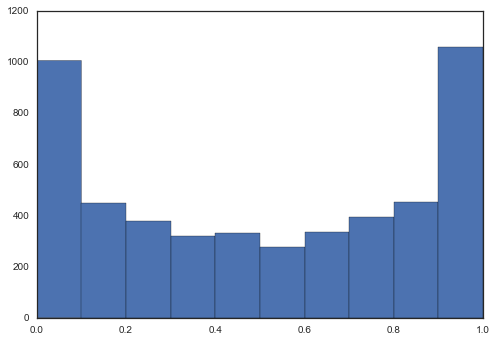

In [21]:
plt.hist(np.random.beta(.5, .5, 5000))

In [22]:
"""
Use Pymc with our prior's above to run mcmc
The mu for the likelihood is the probability we get from theta * number of videos
"""
def prior_uniform(up, down, samples=100000):
    prior_theta = pm.Uniform('theta', lower = 0, upper = 1)
    likelihood = pm.Poisson("observation", mu=prior_theta*(up+down), value=up, observed=True)
    mcmc = pm.MCMC([prior_theta, likelihood])
    mcmc.sample(iter=samples, burn=samples / 4)
    return mcmc

def prior_beta(up, down, samples=100000):
    prior_theta = pm.Beta('theta', alpha=0.5, beta=0.5)
    likelihood = pm.Poisson("observation", mu=prior_theta*(up+down), value=up, observed=True)
    mcmc = pm.MCMC([prior_theta, likelihood])
    mcmc.sample(iter=samples, burn=samples / 4)
    return mcmc

In [23]:
#run our mcmc and get estimated thetas
percentiles_uni = []
percentiles_beta = []
for v in video_votes:
    test = prior_uniform(v[0], v[1])
    theta = test.trace("theta")[:]
    print "\nUniform Prior"
    print "%d upvotes, %d downvotes" % (v[0], v[1])
    print "Estimated mean:", np.mean(theta)
    print "Estimated std:", np.std(theta)
    percentiles_uni += [(v, np.percentile(theta, 5))]
    
    test = prior_beta(v[0], v[1])
    theta = test.trace("theta")[:]
    print "\nBeta Prior"
    print "%d upvotes, %d downvotes" % (v[0], v[1])
    print "Estimated mean:", np.mean(theta)
    print "Estimated std:", np.std(theta)
    percentiles_beta += [(v, np.percentile(theta, 5))]

 [-----------------100%-----------------] 100000 of 100000 complete in 5.7 sec
Uniform Prior
3 upvotes, 0 downvotes
Estimated mean: 0.695796556417
Estimated std: 0.203788107645
 [-----------------100%-----------------] 100000 of 100000 complete in 5.8 sec
Beta Prior
3 upvotes, 0 downvotes
Estimated mean: 0.783739746326
Estimated std: 0.208553949952
 [-----------------100%-----------------] 100000 of 100000 complete in 6.1 sec
Uniform Prior
300 upvotes, 100 downvotes
Estimated mean: 0.752715862507
Estimated std: 0.0431820814954
 [-----------------100%-----------------] 100000 of 100000 complete in 6.0 sec
Beta Prior
300 upvotes, 100 downvotes
Estimated mean: 0.755185208778
Estimated std: 0.0436892292015
 [-----------------100%-----------------] 100000 of 100000 complete in 5.6 sec
Uniform Prior
2 upvotes, 2 downvotes
Estimated mean: 0.55526970287
Estimated std: 0.230281163826
 [-----------------100%-----------------] 100000 of 100000 complete in 5.5 sec
Beta Prior
2 upvotes, 2 downvotes

In each cell we get the estimated posteriors, i.e. most likely probability of getting an upvote given our data and according to our specified prior. Generally the beta prior resulted in slightly higher result than the uniform, as our dataset skewed towards more likely to have an upvote our beta reflected that more strongly than the uniform.

In [24]:
"""
Sort and rank the videos by percentile
"""
print "Uniform prior upvote sorting"
print sorted(percentiles_uni, key=lambda x: x[1])

print "Beta prior upvote sorting"
print sorted(percentiles_beta, key=lambda x: x[1])

Uniform prior upvote sorting
[(array([2, 2]), 0.18441838077560296), (array([3, 0]), 0.31871679606699543), (array([200, 100]), 0.59491698019117056), (array([300, 100]), 0.68375311628333346)]
Beta prior upvote sorting
[(array([2, 2]), 0.16800874924994463), (array([3, 0]), 0.36136404055760502), (array([200, 100]), 0.59529047537945057), (array([300, 100]), 0.68563866305230592)]


The ranking of the videos were consistent between the priors and make sense - the 2/2 upvote sorting got the lowest resulting 5% distribution of the theta at ~.18 and the 300/100 video had the highest as it has both a high proportion of upvotes compared to the others as well as a large number of votes.


This type of system I imagine would work well on symmetric priors where the mean is still around .5, however if we were to skew our prior distribution for example to very likely to have a positive vote, the prior would influence the resulting probabilities so that there wouldn't be too much to differentiate the percentages. The rankings then would lead to more randomness as they'd all be very close.